In [1]:
import os
import glob

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import ndimage as ndi
from scipy import stats

from skimage import io
from skimage.util import img_as_ubyte
from skimage.exposure import histogram
from skimage.filters import sobel
from skimage.morphology import watershed
from skimage.feature import canny
from skimage.draw import circle
#sns.set()

In [18]:
img_dir = "/Users/gonzalovidal/Gonzalo/Synthetic Biology/Corchea/Fluts_C3" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort()
data = []
for f1 in files:
    imraw = io.imread(f1)
    data.append(imraw)
np_data = np.array(data)

#### Select  mask parameters

In [19]:
mask_channel = 0
mask_time = 50

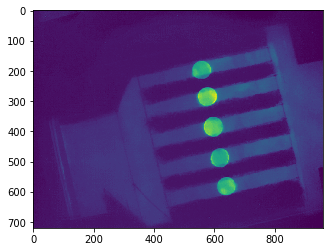

In [20]:
im = np_data[mask_time,:,:,mask_channel]
#Obtain the channel as ubyte
image = img_as_ubyte(im)
plt.imshow(image)

#### MASK Segmentation algorithm

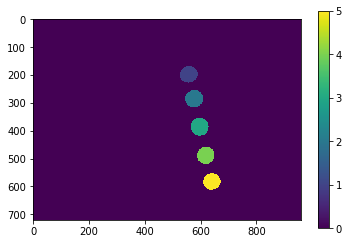

In [21]:
hist, hist_centers = histogram(im)
edges = canny(im/255.)
fill_im = ndi.binary_fill_holes(edges) 
label_objects, nb_labels = ndi.label(edges)
sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 1
mask_sizes[0] = 0
im_cleaned = mask_sizes[label_objects]
markers = np.zeros_like(im)
markers[im < 60] = 1
markers[im > 200] = 2
elevation_map = sobel(im)
markers = np.zeros_like(im) 
markers[im < 30] = 1
markers[im > 100] = 2
segmentation = watershed(elevation_map, markers)
segmentation = ndi.binary_fill_holes(segmentation - 1)
labeled_discs, _ = ndi.label(segmentation)
plt.imshow(labeled_discs)
plt.colorbar()

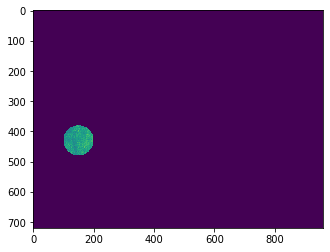

In [23]:
bgcircle = np.zeros((image.shape), dtype=np.uint8)
rr, cc = circle(430, 150, 50)
bgcircle[rr, cc] = 1
areabg = np.sum(bgcircle)
plt.imshow(bgcircle*np_data[1,:,:,1])

#### Create Corchea_df and set the time

In [24]:
columns = {'Time':[],'Sample':[],'Value':[],'Name':[]}
Corchea_df = pd.DataFrame(columns)
time = np_data.shape[0]
Corchea_df

,Time,Sample,Value,Name


In [25]:
for t in range(time):   
    for disc in range(1,6): #the complement is the disc 0
        sample = labeled_discs==disc
        area = np.sum(sample)#quit this from for loop and put calculate only 1 time
        rbgfluo = np.sum(bgcircle*np_data[t,:,:,0])
        ravbgfluo = rbgfluo/areabg
        gbgfluo = np.sum(bgcircle*np_data[t,:,:,1])
        gavbgfluo = gbgfluo/areabg
        rfluo = np.sum(sample*np_data[t,:,:,0])
        ravfluo = (rfluo/area)/ravbgfluo
        gfluo = np.sum(sample*np_data[t,:,:,1])
        gavfluo = (gfluo/area)/gavbgfluo
        
        d_fluo_av_r = {'Time':t,'Sample':disc,'Value':ravfluo,'Name':'RFP'}
        pd_fluo_av_r = pd.DataFrame([d_fluo_av_r])
        d_fluo_av_g = {'Time':t,'Sample':disc,'Value':gavfluo,'Name':'GFP'}
        pd_fluo_av_g = pd.DataFrame([d_fluo_av_g])
        dbg_fluo_av_r = {'Time':t,'Sample':disc,'Value':ravbgfluo,'Name':'RFP_bg'}
        pd_bg_fluo_av_r = pd.DataFrame([dbg_fluo_av_r])
        
        Corchea_df = Corchea_df.append(pd_fluo_av_r,ignore_index=True )
        Corchea_df = Corchea_df.append(pd_fluo_av_g,ignore_index=True )

# Run this to see the background
for t in range(time):   
    rbgfluo = np.sum(bgcircle*np_data[t,:,:,0])
    ravbgfluo = rbgfluo/areabg
    gbgfluo = np.sum(bgcircle*np_data[t,:,:,1])
    gavbgfluo = gbgfluo/areabg
    dbg_fluo_av_r = {'Time':t,'Sample':disc,'Value':ravbgfluo,'Name':'RFP_bg'}
    pd_bg_fluo_av_r = pd.DataFrame([dbg_fluo_av_r])
    dbg_fluo_av_g = {'Time':t,'Sample':disc,'Value':gavbgfluo,'Name':'GFP_bg'}
    pd_bg_fluo_av_g = pd.DataFrame([dbg_fluo_av_g])

    Corchea_df = Corchea_df.append(pd_bg_fluo_av_r,ignore_index=True )
    Corchea_df = Corchea_df.append(pd_bg_fluo_av_g,ignore_index=True )

In [26]:
Corchea_df

,Time,Sample,Value,Name
0,0.0,1.0,2.962106,RFP
1,0.0,1.0,2.184283,GFP
2,0.0,2.0,4.597436,RFP
3,0.0,2.0,2.597598,GFP
4,0.0,3.0,4.440570,RFP
...,...,...,...,...
6795,679.0,3.0,2.448477,GFP
6796,679.0,4.0,8.021131,RFP
6797,679.0,4.0,2.686796,GFP
6798,679.0,5.0,8.546730,RFP


In [10]:
Corchea_df.describe()

,Time,Sample,Value
count,3810.000000,3810.000000,3810.000000
mean,190.000000,3.000000,57.952003
std,109.999284,1.414399,40.019473
min,0.000000,1.000000,10.975784
25%,95.000000,2.000000,20.705890
50%,190.000000,3.000000,26.546359
75%,285.000000,4.000000,98.887064
max,380.000000,5.000000,123.990937


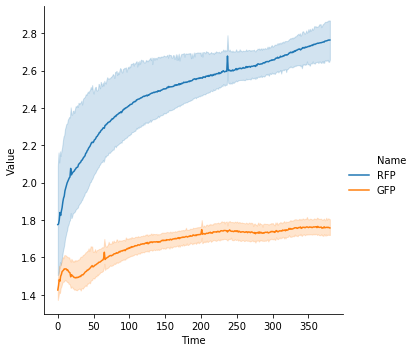

In [17]:
sns.relplot(x="Time", y="Value",
            hue="Name",
            kind="line", data=Corchea_df); #, col="Sample"

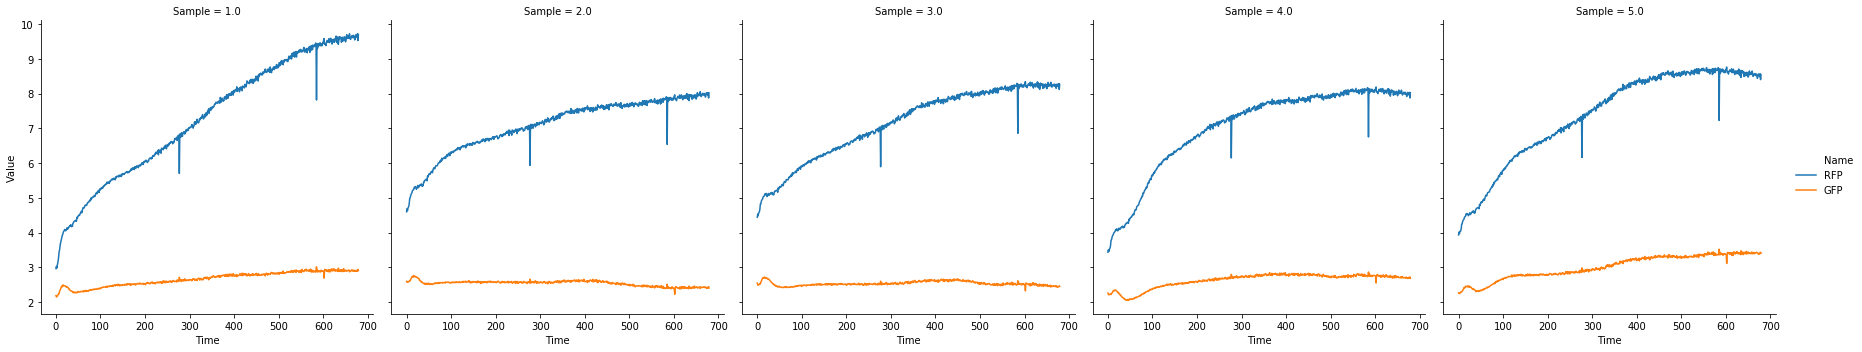

In [28]:
sns.relplot(x="Time", y="Value",
            hue="Name",col="Sample",
            kind="line", data=Corchea_df); #, col="Sample"